Goal A: Compare patient 2486844 (15 encounters) to other patients who have had 10 or more encounters.


Goal B: Predict 1st time patients likelyhood of returning.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/niteen11/DataAnalyticsAcademy/master/Python/dataset_diabetes/diabetic_data.csv')

In [ ]:
# remove '?' input from df
df_noq = df[(df['payer_code'] != '?') & (df['race'] != '?')]
df_noq.groupby(['payer_code'])['patient_nbr'].count().sort_values(ascending=False).head()

,patient_nbr
payer_code,
MC,31605
HM,6128
SP,4763
BC,4541
MD,3434


In [ ]:
df_noq.groupby(['race'])['patient_nbr'].count().sort_values(ascending=False)

,patient_nbr
race,
Caucasian,47568
AfricanAmerican,9957
Hispanic,1044
Other,836
Asian,376


In [ ]:
df_over30 = df_noq[df_noq['readmitted'] == '>30']
df_under30 = df_noq[df_noq['readmitted'] == '<30']
df_none = df_noq[df_noq['readmitted'] == 'NO']

In [ ]:
o3 = df_over30['payer_code'].value_counts().head()
u3 = df_under30['payer_code'].value_counts().head()
n = df_none['payer_code'].value_counts().head()

df_new_race_payer = pd.DataFrame({
    'payer_code': o3.index,   # Taking top payer codes from over30
    'over_30': o3.values,
    'under_30': u3.reindex(o3.index, fill_value=0).values,  # Aligning indices
    'none': n.reindex(o3.index, fill_value=0).values
})

In [ ]:
# Group by race and payer_code, then count occurrences
o3 = df_over30.groupby(['race', 'payer_code']).size().reset_index(name='count')
u3 = df_under30.groupby(['race', 'payer_code']).size().reset_index(name='count')
n = df_none.groupby(['race', 'payer_code']).size().reset_index(name='count')

# Merge the dataframes on race and payer_code
df_new_race_payer = o3.merge(u3, on=['race', 'payer_code'], how='outer', suffixes=('_over30', '_under30'))
df_new_race_payer = df_new_race_payer.merge(n, on=['race', 'payer_code'], how='outer')

# Rename columns for clarity
df_new_race_payer.rename(columns={'count': 'none'}, inplace=True)

# Fill NaN values with 0 (if any categories are missing for certain race-payer_code pairs)
df_new_race_payer.fillna(0, inplace=True)

# Convert counts to integers
df_new_race_payer[['count_over30', 'count_under30', 'none']] = df_new_race_payer[['count_over30', 'count_under30', 'none']].astype(int)

df_new_race_payer['totals'] = df_new_race_payer.apply(lambda row: row['count_over30'] + row['count_under30'] + row['none'], axis=1)

# Display the final table
df_new_race_payer.head()

,race,payer_code,count_over30,count_under30,none,totals
0,AfricanAmerican,BC,240,66,578,884
1,AfricanAmerican,CH,3,2,22,27
2,AfricanAmerican,CM,222,46,246,514
3,AfricanAmerican,CP,91,36,227,354
4,AfricanAmerican,DM,84,26,98,208


In [ ]:
dftop5_race = df_new_race_payer.groupby('race', group_keys=False).apply(
    lambda x: x.nlargest(5, 'totals', keep='all')
).reset_index(drop=True)

dftop5_race['% of group'] = dftop5_race.groupby('race')['totals'].transform(lambda x: (x / x.sum() * 100).round(1))

dftop5_race.head(8)

<ipython-input-19-87cdc1a93cc7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dftop5_race = df_new_race_payer.groupby('race', group_keys=False).apply(


,race,payer_code,count_over30,count_under30,none,totals,% of group
0,AfricanAmerican,MC,1567,551,2539,4657,58.1
1,AfricanAmerican,MD,364,105,588,1057,13.2
2,AfricanAmerican,HM,292,87,518,897,11.2
3,AfricanAmerican,BC,240,66,578,884,11.0
4,AfricanAmerican,CM,222,46,246,514,6.4
5,Asian,MC,30,17,70,117,36.1
6,Asian,SP,28,2,35,65,20.1
7,Asian,MD,13,4,30,47,14.5


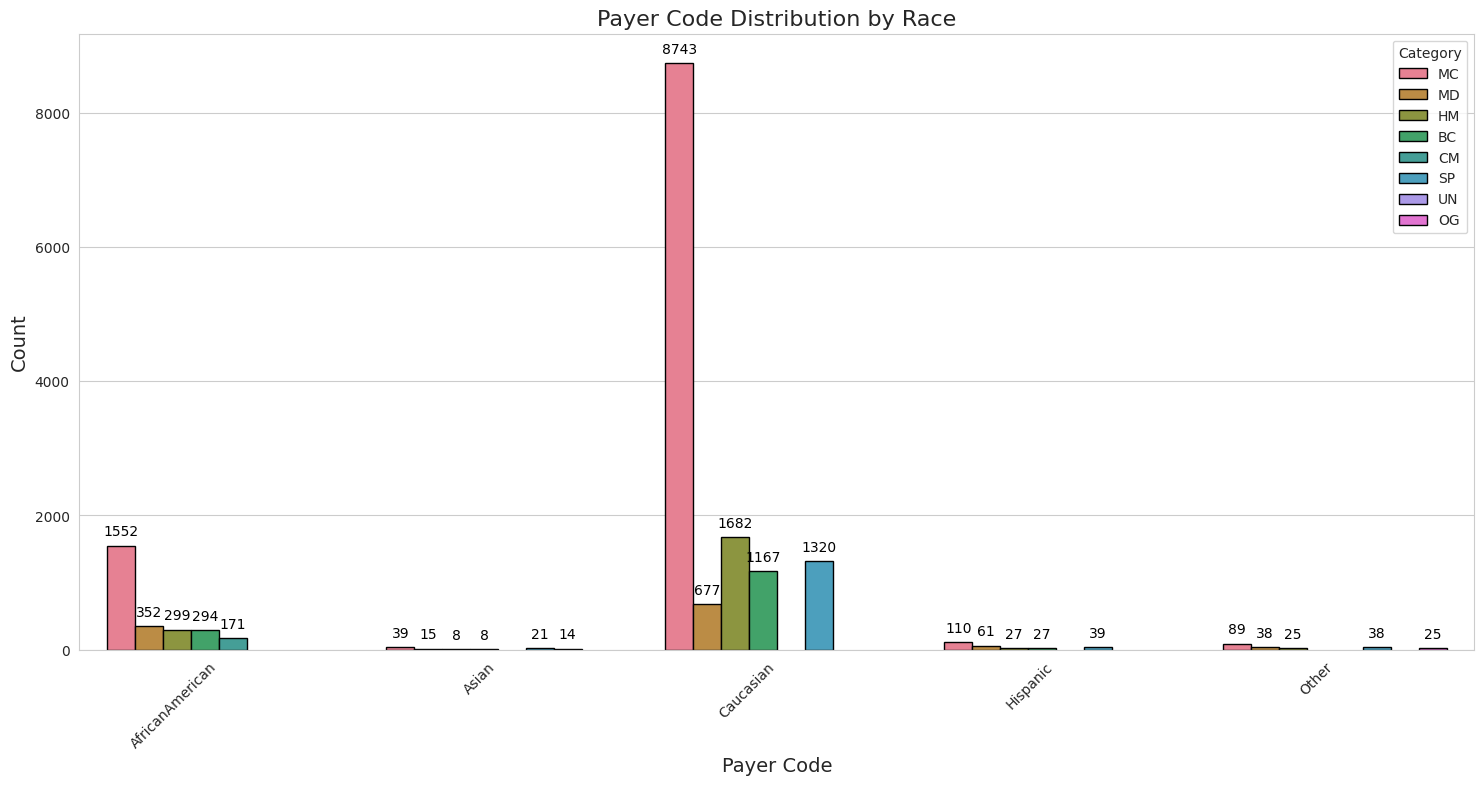

In [ ]:
# Melt the DataFrame for easier visualization
df_melted = dftop5_race.melt(id_vars=['race', 'payer_code'],
                               value_vars=['count_over30', 'count_under30', 'none'],
                               var_name='category', value_name='count')

# Set the plot style
sns.set_style('whitegrid')

# Create the bar plot
plt.figure(figsize=(18, 8))
ax = sns.barplot(data=df_melted, x='race', y='count', errorbar=None,hue='payer_code', palette='husl', edgecolor='black')

# Title and labels
plt.title('Payer Code Distribution by Race', fontsize=16)
plt.xlabel('Payer Code', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars with count values
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.legend(title='Category')
plt.show()

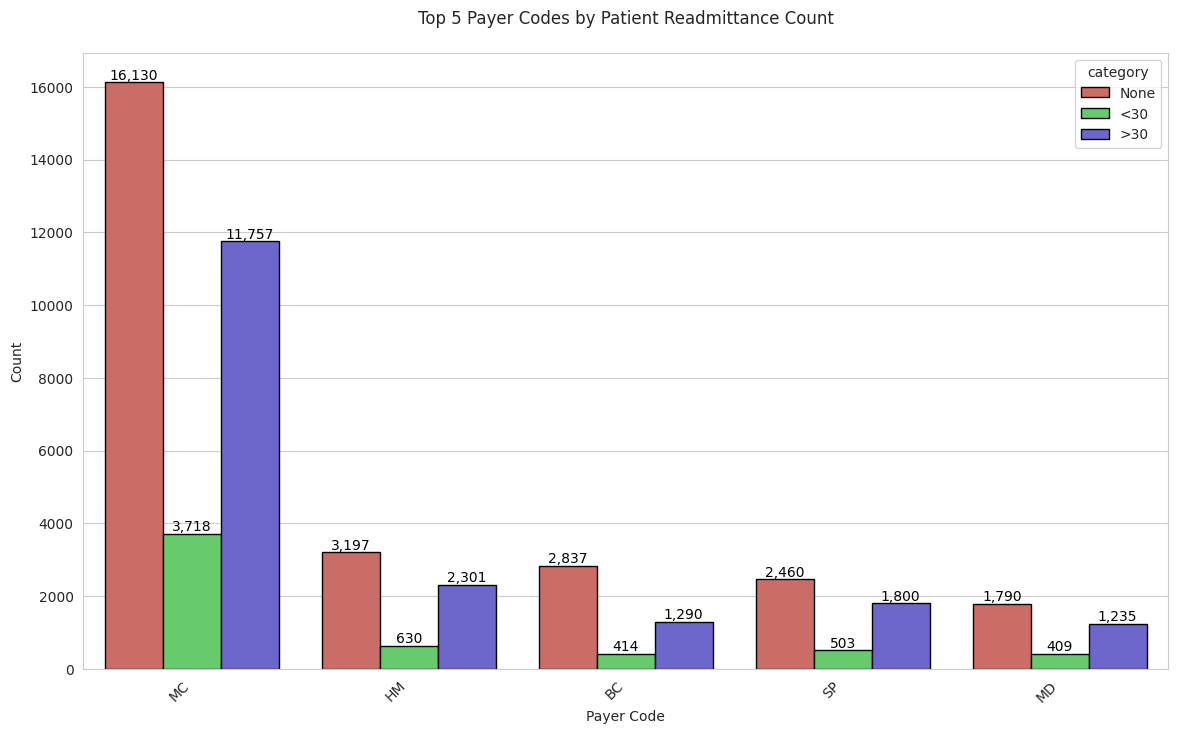

In [ ]:
# Calculate the top 5 payer code counts for each group
df_none_top5 = df_none['payer_code'].value_counts().head(5)
df_under30_top5 = df_under30['payer_code'].value_counts().head(5)
df_over30_top5 = df_over30['payer_code'].value_counts().head(5)

# Create a DataFrame to hold all the data
df_hcbar = pd.DataFrame({
    'payer_code': list(df_none_top5.index) + list(df_under30_top5.index) + list(df_over30_top5.index),
    'count': list(df_none_top5.values) + list(df_under30_top5.values) + list(df_over30_top5.values),
    'category': ['None'] * len(df_none_top5) + ['<30'] * len(df_under30_top5) + ['>30'] * len(df_over30_top5)
})

df_hcbar = df_hcbar[df_hcbar['count'] > 0]

# Set the plot style
sns.set_style('whitegrid')

# Create the bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='payer_code', y='count', data=df_hcbar, hue='category', palette='hls', edgecolor='black')

# Title and labels
plt.title('Top 5 Payer Codes by Patient Readmittance Count\n')
plt.xlabel('Payer Code')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Annotate the bars with the counts
for p in ax.patches:
    # Avoid showing '0' if count is zero
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.show()


In [ ]:
patient_counts = df['patient_nbr'].value_counts()

over_10 = patient_counts[patient_counts >= 10].index
df_10 = df[df['patient_nbr'].isin(over_10)]

mid = patient_counts[(patient_counts > 1) & (patient_counts < 10)].index
df_mid = df[df['patient_nbr'].isin(mid)]

one = patient_counts[patient_counts == 1].index
df_one = df[df['patient_nbr'].isin(one)]

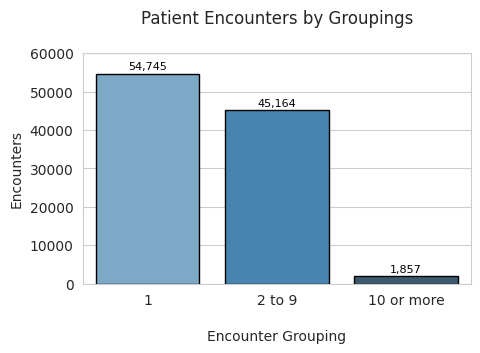

In [ ]:
df_bar = pd.DataFrame({
    'category': ['1', '2 to 9', '10 or more'],
    'value': [df_one['patient_nbr'].count(), df_mid['patient_nbr'].count(), df_10['patient_nbr'].count()]
})

sns.set_style('whitegrid')
plt.figure(figsize=(5, 3))
ax = sns.barplot(x='category', y='value', data=df_bar, hue='category', palette='Blues_d', edgecolor='black', legend=False)

plt.title('Patient Encounters by Groupings\n')
plt.xlabel('\nEncounter Grouping')
plt.ylabel('Encounters')
ax.set_ylim(0, max(df_bar['value']) * 1.1)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

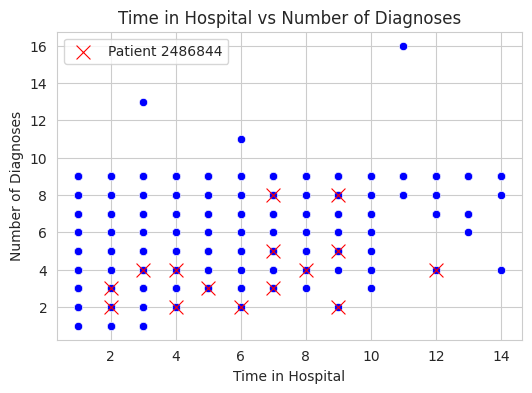

In [ ]:
# highlight ['patient_nbr' == '2486844'] in chart

highlight = df_10[df_10['patient_nbr'] == 2486844]

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_10, x='time_in_hospital', y='number_diagnoses', color='blue')

sns.scatterplot(data=highlight, x='time_in_hospital', y='number_diagnoses', color='red', s=100, label='Patient 2486844', marker='x')

plt.xlabel('Time in Hospital')
plt.ylabel('Number of Diagnoses')
plt.title('Time in Hospital vs Number of Diagnoses')

plt.show()

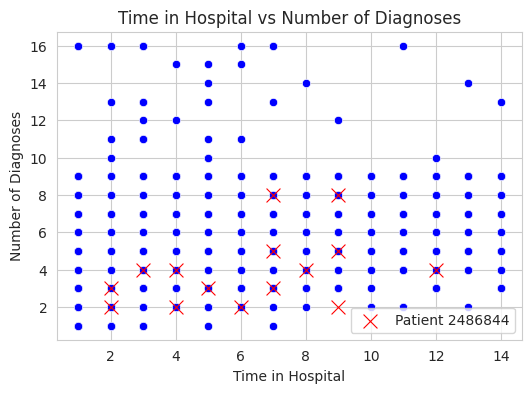

In [ ]:
# highlight ['patient_nbr' == '2486844'] in chart

highlight = df_10[df_10['patient_nbr'] == 2486844]

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_over30, x='time_in_hospital', y='number_diagnoses', color='blue')

sns.scatterplot(data=highlight, x='time_in_hospital', y='number_diagnoses', color='red', s=100, label='Patient 2486844', marker='x')

plt.xlabel('Time in Hospital')
plt.ylabel('Number of Diagnoses')
plt.title('Time in Hospital vs Number of Diagnoses')

plt.show()